# Hackthaon

**Problem Statement**

**We have data from the NHANES agency. We need to cluster the patient of similar kind and label there clusters**

**Import Libraries**

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [15,8]
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cophenet
from sklearn.metrics import silhouette_score 
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN

**Read the data**

In [85]:
df=pd.read_csv("df.csv")
df.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,DRD340,DRD360,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,LBXSAL,LBDSALSI,LBXSAPSI
0,73557,8,2,1,69,NaN,4,4,1,NaN,...,6.586219,-6.527018,9.182882,-9.018023,-6.181923,5.151193,-9.708139,2.814690,-2.712184,-6.811191
1,73558,8,2,1,54,NaN,3,3,1,NaN,...,-9.588554,1.863741,-9.378731,8.289190,-2.561066,-3.755943,1.406037,7.590942,0.480820,-4.636475
2,73559,8,2,1,72,NaN,3,3,2,NaN,...,-5.229054,6.379788,-9.433054,-9.285869,9.248429,-7.439368,8.374918,8.401561,-9.936335,0.913262
3,73560,8,2,1,9,NaN,3,3,1,119.0,...,7.428271,-1.193575,6.972074,-0.257756,-5.087773,8.581422,4.767615,9.760521,-4.708915,7.624684
4,73561,8,2,2,73,NaN,3,3,1,NaN,...,2.125105,-2.906226,1.977286,-1.322955,-1.034636,6.702919,-1.735375,-4.799543,1.194572,-7.098007


In [86]:
df.shape

(9813, 636)

From above we can see that we have 9813 patient sample data and 636 features are present 

# **Exploratory Data Analysis**

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9813 entries, 0 to 9812
Columns: 636 entries, SEQN to LBXSAPSI
dtypes: float64(615), int64(21)
memory usage: 47.6 MB


We can see that in our data we don't have the categorical values we only have the int and float data

**Outliers Treatment**

In [88]:
Q1 = df.quantile(0.25)

Q3 = df.quantile(0.75)

IQR = Q3 - Q1

print(IQR)

SEQN        5099.000000
SDDSRVYR       0.000000
RIDSTATR       0.000000
RIAGENDR       1.000000
RIDAGEYR      42.000000
               ...     
URXCRS         9.022761
URDACT        10.552067
LBXSAL        10.147778
LBDSALSI       8.683529
LBXSAPSI       7.555855
Length: 636, dtype: float64


**Missing Value Treatment**

In [89]:
Total = df.isnull().sum().sort_values(ascending=False)          

Percent = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending=False)   

missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])    
missing_data[missing_data['Percentage of Missing Values'] >= 70]


,Total,Percentage of Missing Values
DRQSDT5,9813,100.000000
DRQSDT6,9809,99.959238
DRQSDT12,9805,99.918475
DRD370PQ,9803,99.898094
DRD370JQ,9801,99.877713
...,...,...
WTSB2YR,7036,71.700805
WTSOG2YR,6904,70.355651
PHAFSTHR,6904,70.355651
PHAFSTMN,6904,70.355651


In [90]:
df = df.drop(df.columns[df.apply(lambda col: col.isnull().sum()/len(df) > 0.60)], axis=1)

In [91]:
df.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,DRD340,DRD360,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,LBXSAL,LBDSALSI,LBXSAPSI
0,73557,8,2,1,69,4,4,1,NaN,1.0,...,6.586219,-6.527018,9.182882,-9.018023,-6.181923,5.151193,-9.708139,2.814690,-2.712184,-6.811191
1,73558,8,2,1,54,3,3,1,NaN,2.0,...,-9.588554,1.863741,-9.378731,8.289190,-2.561066,-3.755943,1.406037,7.590942,0.480820,-4.636475
2,73559,8,2,1,72,3,3,2,NaN,1.0,...,-5.229054,6.379788,-9.433054,-9.285869,9.248429,-7.439368,8.374918,8.401561,-9.936335,0.913262
3,73560,8,2,1,9,3,3,1,119.0,NaN,...,7.428271,-1.193575,6.972074,-0.257756,-5.087773,8.581422,4.767615,9.760521,-4.708915,7.624684
4,73561,8,2,2,73,3,3,1,NaN,2.0,...,2.125105,-2.906226,1.977286,-1.322955,-1.034636,6.702919,-1.735375,-4.799543,1.194572,-7.098007


In [92]:
Total = df.isnull().sum().sort_values(ascending=False)          

Percent = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending=False)   

missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])    
missing_data

,Total,Percentage of Missing Values
URXUTRI,5756,58.656884
LBDWFL,5713,58.218689
RIDEXAGM,5600,57.067156
ORXH16,4756,48.466320
ORXH71,4756,48.466320
...,...,...
DR1TALCO,0,0.000000
SDDSRVYR,0,0.000000
DR1DRSTZ,0,0.000000
WTDRD1,0,0.000000


In [93]:
df=df.fillna(df.median())

In [94]:
Total = df.isnull().sum().sort_values(ascending=False)          

Percent = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending=False)   

missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])    
missing_data

,Total,Percentage of Missing Values
SEQN,0,0.0
ORXH62,0,0.0
ORXH71,0,0.0
ORXH70,0,0.0
ORXH69,0,0.0
...,...,...
DRD370S,0,0.0
DRD370R,0,0.0
DRD370Q,0,0.0
DRD370P,0,0.0


In [95]:
df.shape

(9813, 305)

In [96]:
df.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,DRD340,DRD360,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,LBXSAL,LBDSALSI,LBXSAPSI
0,73557,8,2,1,69,4,4,1,103.0,1.0,...,6.586219,-6.527018,9.182882,-9.018023,-6.181923,5.151193,-9.708139,2.814690,-2.712184,-6.811191
1,73558,8,2,1,54,3,3,1,103.0,2.0,...,-9.588554,1.863741,-9.378731,8.289190,-2.561066,-3.755943,1.406037,7.590942,0.480820,-4.636475
2,73559,8,2,1,72,3,3,2,103.0,1.0,...,-5.229054,6.379788,-9.433054,-9.285869,9.248429,-7.439368,8.374918,8.401561,-9.936335,0.913262
3,73560,8,2,1,9,3,3,1,119.0,2.0,...,7.428271,-1.193575,6.972074,-0.257756,-5.087773,8.581422,4.767615,9.760521,-4.708915,7.624684
4,73561,8,2,2,73,3,3,1,103.0,2.0,...,2.125105,-2.906226,1.977286,-1.322955,-1.034636,6.702919,-1.735375,-4.799543,1.194572,-7.098007


# Scale The Data

In [97]:
X_norm = StandardScaler()
X_filtered = df.drop('SEQN',axis=1)

num_norm = X_norm.fit_transform(X_filtered)


X = pd.DataFrame(num_norm, columns = X_filtered.columns)

X.head()

,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMDBORN4,...,DRD340,DRD360,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,LBXSAL,LBDSALSI,LBXSAPSI
0,0.0,0.0,-1.015508,1.531807,0.725587,0.449104,-1.017166,-0.042012,-4.112188,-0.139098,...,1.248422,-1.086135,1.794467,-2.029602,-1.129412,0.548827,-1.740461,0.000698,-0.504733,-1.184963
1,0.0,0.0,-1.015508,0.916959,-0.066337,-0.172835,-1.017166,-0.042012,0.229168,-0.139098,...,-1.178272,0.283619,-1.571961,1.540897,-0.518483,-1.046665,0.059775,0.828889,0.151146,-0.764688
2,0.0,0.0,-1.015508,1.654776,-0.066337,-0.172835,0.983124,-0.042012,-4.112188,-0.139098,...,-0.524218,1.020844,-1.581814,-2.084860,1.474072,-1.706459,1.188571,0.969449,-1.988656,0.307827
3,0.0,0.0,-1.015508,-0.927582,-0.066337,-0.172835,-1.017166,0.307586,0.229168,-0.139098,...,1.374755,-0.215474,1.393503,-0.222349,-0.944801,1.163267,0.604272,1.205089,-0.914885,1.604843
4,0.0,0.0,0.984729,1.695766,-0.066337,-0.172835,-1.017166,-0.042012,0.229168,-0.139098,...,0.579123,-0.495056,0.487623,-0.442100,-0.260936,0.826780,-0.449060,-1.319593,0.297759,-1.240391


In [98]:
Y=df[['SEQN']]
Y.head()

,SEQN
0,73557
1,73558
2,73559
3,73560
4,73561


In [99]:
df1=pd.concat((Y,X),axis=1)

In [100]:
df1.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,DRD340,DRD360,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,LBXSAL,LBDSALSI,LBXSAPSI
0,73557,0.0,0.0,-1.015508,1.531807,0.725587,0.449104,-1.017166,-0.042012,-4.112188,...,1.248422,-1.086135,1.794467,-2.029602,-1.129412,0.548827,-1.740461,0.000698,-0.504733,-1.184963
1,73558,0.0,0.0,-1.015508,0.916959,-0.066337,-0.172835,-1.017166,-0.042012,0.229168,...,-1.178272,0.283619,-1.571961,1.540897,-0.518483,-1.046665,0.059775,0.828889,0.151146,-0.764688
2,73559,0.0,0.0,-1.015508,1.654776,-0.066337,-0.172835,0.983124,-0.042012,-4.112188,...,-0.524218,1.020844,-1.581814,-2.084860,1.474072,-1.706459,1.188571,0.969449,-1.988656,0.307827
3,73560,0.0,0.0,-1.015508,-0.927582,-0.066337,-0.172835,-1.017166,0.307586,0.229168,...,1.374755,-0.215474,1.393503,-0.222349,-0.944801,1.163267,0.604272,1.205089,-0.914885,1.604843
4,73561,0.0,0.0,0.984729,1.695766,-0.066337,-0.172835,-1.017166,-0.042012,0.229168,...,0.579123,-0.495056,0.487623,-0.442100,-0.260936,0.826780,-0.449060,-1.319593,0.297759,-1.240391


In [101]:
df1.shape

(9813, 305)

# KMeans Clustering

In [102]:
wcss  = []

for i in range(1,21):
    kmeans = KMeans(n_clusters = i, random_state = 10)
    kmeans.fit(df1)
    wcss.append(kmeans.inertia_)

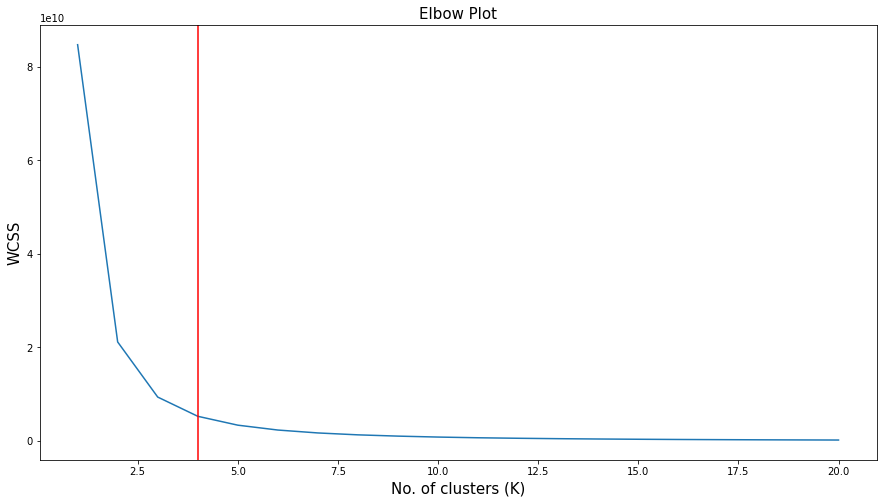

In [103]:

plt.plot(range(1,21), wcss)

plt.title('Elbow Plot', fontsize = 15)
plt.xlabel('No. of clusters (K)', fontsize = 15)
plt.ylabel('WCSS', fontsize = 15)
plt.axvline(x = 4, color = 'red')
# display the plot
plt.show()

**Interpretation**: We can see that the for K = 4, there is an elbow in the plot. Before this elbow point, the WCSS is decreasing rapidly and after K = 4, the WCSS is decreasing slowly.

Now, let us use the silhouette score method to identify the optimal value of K.

In [104]:
n_clusters = [2, 3, 4, 5, 6]

for K in n_clusters:
    cluster = KMeans (n_clusters= K, random_state= 10)
    predict = cluster.fit_predict(df1)
    score = silhouette_score(df1, predict, random_state= 10)
    print ("For {} clusters the silhouette score is {})".format(K, score))

For 2 clusters the silhouette score is 0.6265445616984259)
For 3 clusters the silhouette score is 0.5902173592446129)
For 4 clusters the silhouette score is 0.5715537248433095)
For 5 clusters the silhouette score is 0.559782706670169)
For 6 clusters the silhouette score is 0.5528059525516481)


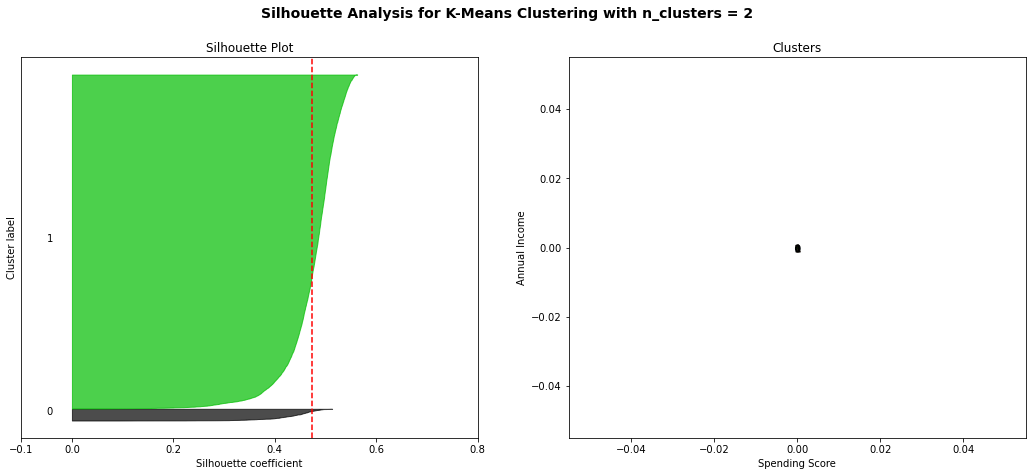

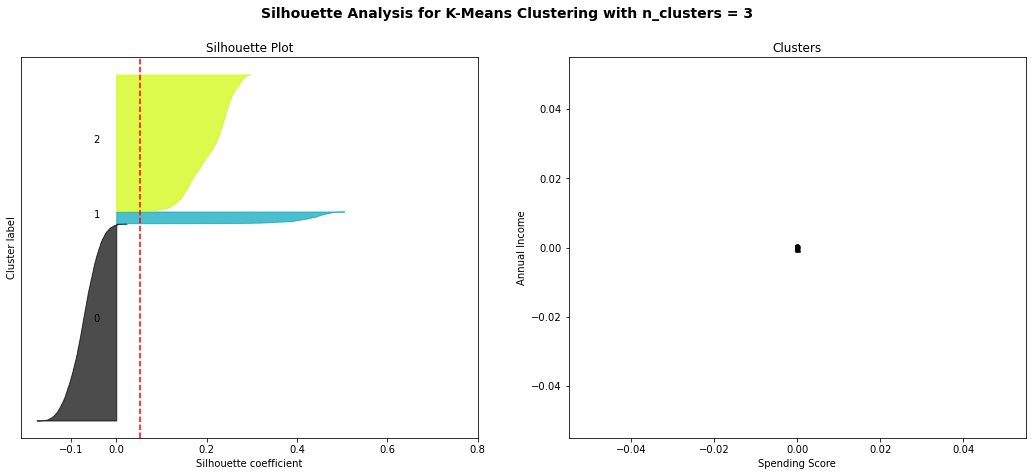

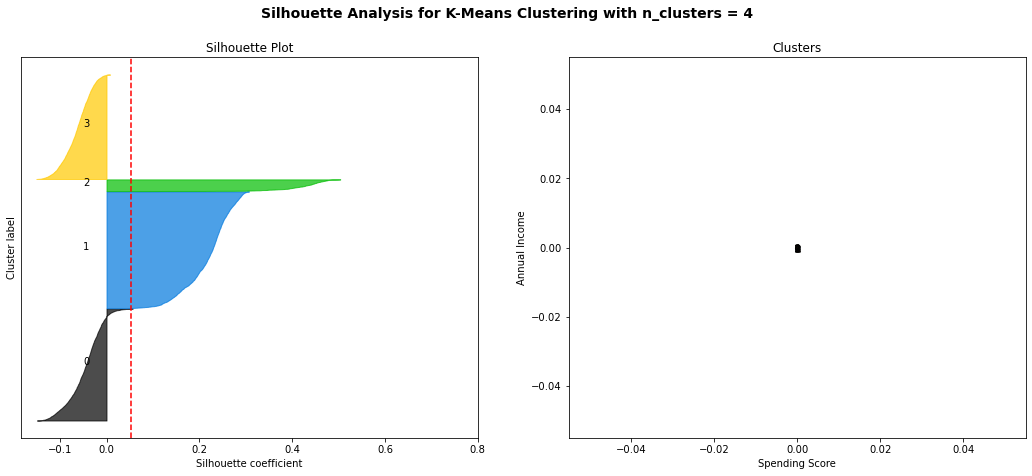

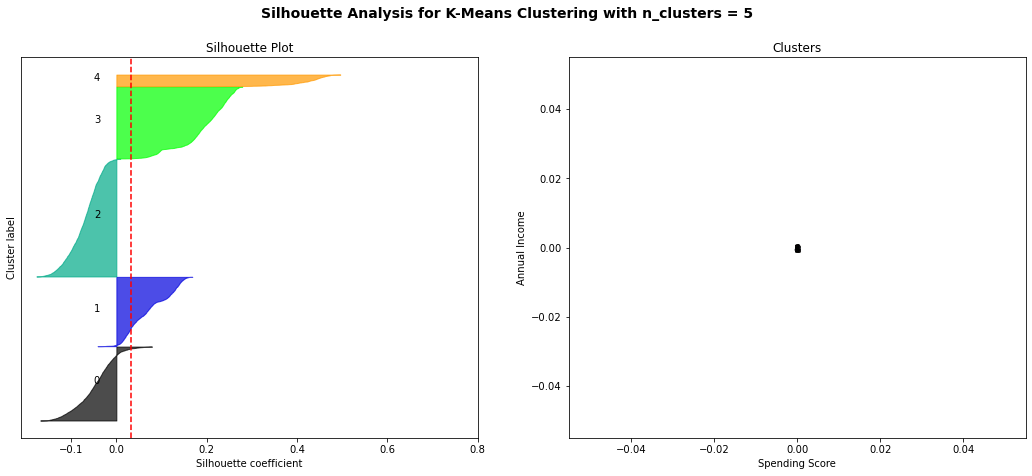

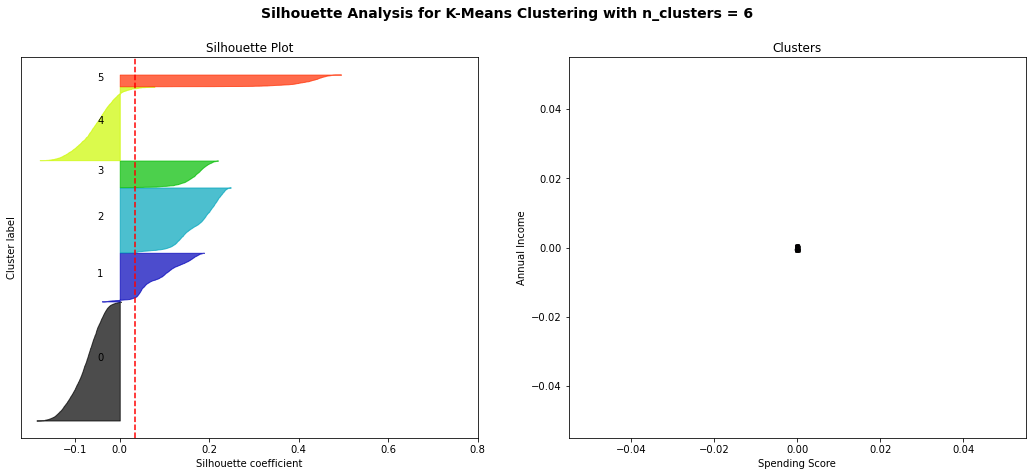

In [105]:
# consider the number of clusters
n_clusters = [2, 3, 4, 5, 6]

# consider an array of the data
X = np.array(X)

# for each value of K, plot the silhouette plot the clusters formed
for K in n_clusters:
    
    # create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    # set the figure size
    fig.set_size_inches(18, 7)

    # the 1st subplot is the silhouette plot
    # initialize the cluster with 'K' value and a random generator
    model = KMeans(n_clusters = K, random_state = 10)
    
    # fit and predict on the scaled data
    cluster_labels = model.fit_predict(X)

    # the 'silhouette_score()' gives the average value for all the samples
    silhouette_avg = silhouette_score(X, cluster_labels)
    
    # Compute the silhouette coefficient for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(K):
        
        # aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        
        # sort the silhouette coefficient
        ith_cluster_silhouette_values.sort()
        
        # calculate the size of the cluster
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # color each cluster 
        color = cm.nipy_spectral(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # compute the new y_lower for next plot
        y_lower = y_upper + 10 

    # set the axes and plot label
    ax1.set_title("Silhouette Plot")
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Cluster label")

    # plot the vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    # clear the y-axis ticks
    ax1.set_yticks([])  
    
    # set the ticks for x-axis 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8])

    
    # 2nd plot showing the actual clusters formed
    # consider different color for each cluster
    colors = cm.nipy_spectral(cluster_labels.astype(float) / K)
    
    # plot a scatter plot to visualize the clusters
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # label the cluster centers
    centers = model.cluster_centers_
    
    # display the cluster center with cluster number
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    
    # add the axes and plot title
    ax2.set_title("Clusters")
    ax2.set_xlabel("Spending Score")
    ax2.set_ylabel("Annual Income")
    
    # set the common title for subplots
    plt.suptitle(("Silhouette Analysis for K-Means Clustering with n_clusters = %d" % K), fontsize=14, 
                 fontweight='bold')

# display the plot
plt.show()

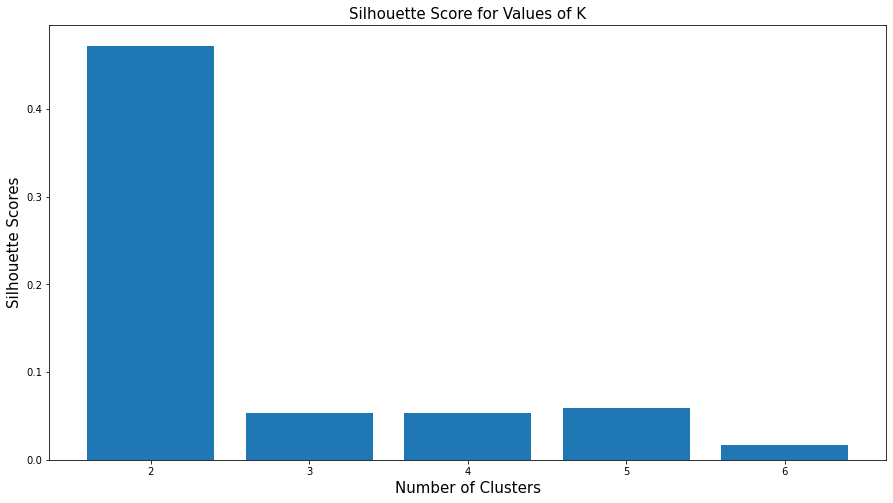

In [106]:
# consider different values of K
K = [2,3,4,5,6]

# consider an empty list tot store the Silhouette score
silhouette_scores = [] 

# consider a for loop to perform clustering for different values of K
for i in K:
    
    # instantiate clustering for each value of K
    model = KMeans(n_clusters = i) 
    
    # calculate the Silhouette score and append to the list 'silhouette_scores'
    silhouette_scores.append(silhouette_score(X, model.fit_predict(X))) 
    
# plot the Silhouette score for different K
plt.bar(K, silhouette_scores) 

# set the axes and plot labels
# set the font size using 'fontsize'
plt.title('Silhouette Score for Values of K', fontsize = 15)
plt.xlabel('Number of Clusters', fontsize = 15) 
plt.ylabel('Silhouette Scores', fontsize = 15)

# display the plot
plt.show()

**Interpretation**: The above plot shows the silhouette plot and the clusters formed for each value of K. From the above plot we can see the silhoutte score is having high value for K=2,3,4 clusters. All the clusters does not have the outliers.

So we can consider for K means ideal no. od clusters are 2,3,4

# Build the clusters

**No. of clusters = 2**

In [107]:
new_clusters = KMeans(n_clusters = 2, random_state = 10)

new_clusters.fit(X)

df['Cluster'] = new_clusters.labels_

In [108]:
df.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,DRD360,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,LBXSAL,LBDSALSI,LBXSAPSI,Cluster
0,73557,8,2,1,69,4,4,1,103.0,1.0,...,-6.527018,9.182882,-9.018023,-6.181923,5.151193,-9.708139,2.814690,-2.712184,-6.811191,1
1,73558,8,2,1,54,3,3,1,103.0,2.0,...,1.863741,-9.378731,8.289190,-2.561066,-3.755943,1.406037,7.590942,0.480820,-4.636475,1
2,73559,8,2,1,72,3,3,2,103.0,1.0,...,6.379788,-9.433054,-9.285869,9.248429,-7.439368,8.374918,8.401561,-9.936335,0.913262,1
3,73560,8,2,1,9,3,3,1,119.0,2.0,...,-1.193575,6.972074,-0.257756,-5.087773,8.581422,4.767615,9.760521,-4.708915,7.624684,1
4,73561,8,2,2,73,3,3,1,103.0,2.0,...,-2.906226,1.977286,-1.322955,-1.034636,6.702919,-1.735375,-4.799543,1.194572,-7.098007,1


In [109]:
df.Cluster.value_counts()

1    9480
0     333
Name: Cluster, dtype: int64

**No. of clusters = 3**

In [110]:
new_clusters = KMeans(n_clusters = 3, random_state = 10)

new_clusters.fit(X)

df['Cluster'] = new_clusters.labels_
df.head()
df.Cluster.value_counts()

0    5598
2    3882
1     333
Name: Cluster, dtype: int64

In [111]:
df.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,DRD360,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,LBXSAL,LBDSALSI,LBXSAPSI,Cluster
0,73557,8,2,1,69,4,4,1,103.0,1.0,...,-6.527018,9.182882,-9.018023,-6.181923,5.151193,-9.708139,2.814690,-2.712184,-6.811191,0
1,73558,8,2,1,54,3,3,1,103.0,2.0,...,1.863741,-9.378731,8.289190,-2.561066,-3.755943,1.406037,7.590942,0.480820,-4.636475,0
2,73559,8,2,1,72,3,3,2,103.0,1.0,...,6.379788,-9.433054,-9.285869,9.248429,-7.439368,8.374918,8.401561,-9.936335,0.913262,0
3,73560,8,2,1,9,3,3,1,119.0,2.0,...,-1.193575,6.972074,-0.257756,-5.087773,8.581422,4.767615,9.760521,-4.708915,7.624684,2
4,73561,8,2,2,73,3,3,1,103.0,2.0,...,-2.906226,1.977286,-1.322955,-1.034636,6.702919,-1.735375,-4.799543,1.194572,-7.098007,0


**No. of clusters = 4**

In [112]:
new_clusters = KMeans(n_clusters = 4, random_state = 10)

new_clusters.fit(X)

df['Cluster'] = new_clusters.labels_
df.head()
df.Cluster.value_counts()

1    3323
0    3185
3    2972
2     333
Name: Cluster, dtype: int64

# Hierarchical Clustering

**Linkage Methods**

**Single linkage methods**

In [113]:
link_mat = linkage(X, method = 'single'') 
print(link_mat[0:10])

[[1.19700000e+03 2.67000000e+03 1.55930461e-02 2.00000000e+00]
 [4.14000000e+02 5.27000000e+03 1.84357176e-02 2.00000000e+00]
 [4.67800000e+03 9.80300000e+03 2.04408950e-02 2.00000000e+00]
 [4.57400000e+03 5.11500000e+03 1.38015052e-01 2.00000000e+00]
 [9.53000000e+02 5.93700000e+03 2.52521617e-01 2.00000000e+00]
 [1.54300000e+03 4.50900000e+03 3.17042810e-01 2.00000000e+00]
 [6.60900000e+03 7.35700000e+03 3.59553153e-01 2.00000000e+00]
 [9.79000000e+02 2.06500000e+03 3.61561504e-01 2.00000000e+00]
 [2.60100000e+03 7.25800000e+03 5.32956835e-01 2.00000000e+00]
 [1.07200000e+03 1.74700000e+03 5.38196921e-01 2.00000000e+00]]


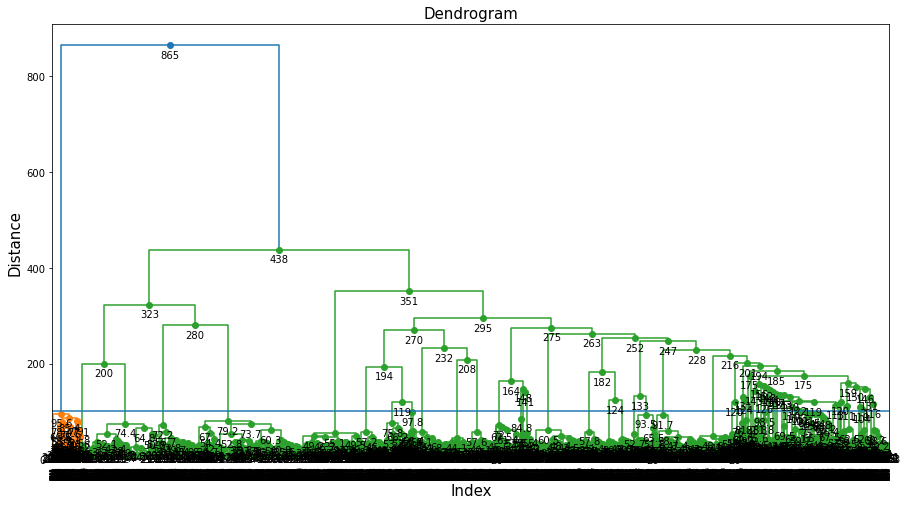

In [114]:
# plot the dendrogram
# pass the linkage matrix
dendro = dendrogram(link_mat)

# annotate the distance on the y-axis for distance > 20
# 'dendro' returns the dictionary containing x,y coordinates and the color list for each merge
# the 'icoord' returns the x-coordinates for the rectangle that represents the merging
# the 'dcoord' returns the y-coordinates (distance) for the each corner of the rectangle that represents the merging
for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
    
    # consider 'x' as the x-coordinate of the average distance on the merging line
    x = sum(i[1:3])/2
    
    # consider 'y' as the distance at which the merging occurs 
    y = d[1]
    
    # pass the if-condition for annotation
    if y > 20:
        
        # plot the bullet and annotate the merging distance 'y'
        plt.plot(x, y, 'o', c=c)
        
        # pass the conditions to annotate the distance
        plt.annotate("%.3g" % y, (x, y), xytext=(0, -5), textcoords='offset points', va='top', ha='center')

        
# plot the line to cut the dendrogram
plt.axhline(y = 100)

# set the axes and plot labels
# set the font size using 'fontsize'
plt.title('Dendrogram', fontsize = 15)
plt.xlabel('Index', fontsize = 15)
plt.ylabel('Distance', fontsize = 15)

# display the plot
plt.show()

In [115]:
eucli_dist = euclidean_distances(X)

# the above code will return the matrix of 5192x5192
# consider only the array of upper triangular matrix
# k=1 considers the upper triangular values without the diagonal elements
dist_array = eucli_dist[np.triu_indices(9813, k = 1)]

# pass the linkage matrix and actual distance
# 1st output of the cophenet() is the correlation coefficient
coeff, cophenet_dist = cophenet(link_mat, dist_array)

# print the cophenetic correlation coefficient
print(coeff)

0.4968029902993211


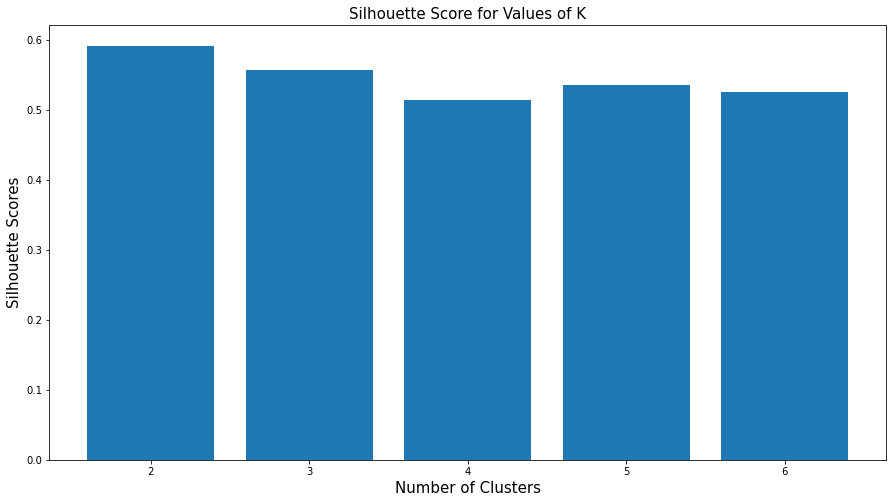

In [116]:
# consider different values of K
K = [2,3,4,5,6]

# consider an empty list tot store the Silhouette score
silhouette_scores = [] 

# consider a for loop to perform clustering for different values of K
for i in K:
    
    # instantiate clustering for each value of K
    model = AgglomerativeClustering(n_clusters = i) 
    
    # calculate the Silhouette score and append to the list 'silhouette_scores'
    silhouette_scores.append(silhouette_score(df1, model.fit_predict(df1))) 
    
# plot the Silhouette score for different K
plt.bar(K, silhouette_scores) 

# set the axes and plot labels
# set the font size using 'fontsize'
plt.title('Silhouette Score for Values of K', fontsize = 15)
plt.xlabel('Number of Clusters', fontsize = 15) 
plt.ylabel('Silhouette Scores', fontsize = 15)

# display the plot
plt.show()

In [117]:
clusters = AgglomerativeClustering(n_clusters=2, linkage='ward')

clusters.fit(X)

AgglomerativeClustering()

In [118]:

df['Cluster'] = clusters.labels_

df.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,DRD360,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,LBXSAL,LBDSALSI,LBXSAPSI,Cluster
0,73557,8,2,1,69,4,4,1,103.0,1.0,...,-6.527018,9.182882,-9.018023,-6.181923,5.151193,-9.708139,2.814690,-2.712184,-6.811191,0
1,73558,8,2,1,54,3,3,1,103.0,2.0,...,1.863741,-9.378731,8.289190,-2.561066,-3.755943,1.406037,7.590942,0.480820,-4.636475,0
2,73559,8,2,1,72,3,3,2,103.0,1.0,...,6.379788,-9.433054,-9.285869,9.248429,-7.439368,8.374918,8.401561,-9.936335,0.913262,0
3,73560,8,2,1,9,3,3,1,119.0,2.0,...,-1.193575,6.972074,-0.257756,-5.087773,8.581422,4.767615,9.760521,-4.708915,7.624684,0
4,73561,8,2,2,73,3,3,1,103.0,2.0,...,-2.906226,1.977286,-1.322955,-1.034636,6.702919,-1.735375,-4.799543,1.194572,-7.098007,0


In [119]:
df['Cluster'].value_counts()

0    9483
1     330
Name: Cluster, dtype: int64

In [120]:
link_mat = linkage(df1, method = 'ward') 
print(link_mat[0:10])

[[8.97900000e+03 8.98000000e+03 3.68902418e+00 2.00000000e+00]
 [5.61600000e+03 5.61800000e+03 4.27890834e+00 2.00000000e+00]
 [6.95900000e+03 6.96100000e+03 5.32801809e+00 2.00000000e+00]
 [1.17900000e+03 1.18100000e+03 5.53315028e+00 2.00000000e+00]
 [5.02800000e+03 5.02900000e+03 5.53512848e+00 2.00000000e+00]
 [6.91200000e+03 6.91400000e+03 5.86440373e+00 2.00000000e+00]
 [3.05600000e+03 3.05900000e+03 6.00885480e+00 2.00000000e+00]
 [9.31400000e+03 9.31500000e+03 6.28031400e+00 2.00000000e+00]
 [7.02500000e+03 7.02900000e+03 6.36749875e+00 2.00000000e+00]
 [9.26000000e+02 9.27000000e+02 6.36912291e+00 2.00000000e+00]]


# DBSCAN

In [121]:
model = DBSCAN(eps = 0.8, min_samples = 2)
model.fit(df1)

DBSCAN(eps=0.8, min_samples=2)

In [122]:
(set(model.labels_))

{-1}

In [123]:
df['Cluster_DBSCAN'] = model.labels_
df.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,LBXSAL,LBDSALSI,LBXSAPSI,Cluster,Cluster_DBSCAN
0,73557,8,2,1,69,4,4,1,103.0,1.0,...,9.182882,-9.018023,-6.181923,5.151193,-9.708139,2.814690,-2.712184,-6.811191,0,-1
1,73558,8,2,1,54,3,3,1,103.0,2.0,...,-9.378731,8.289190,-2.561066,-3.755943,1.406037,7.590942,0.480820,-4.636475,0,-1
2,73559,8,2,1,72,3,3,2,103.0,1.0,...,-9.433054,-9.285869,9.248429,-7.439368,8.374918,8.401561,-9.936335,0.913262,0,-1
3,73560,8,2,1,9,3,3,1,119.0,2.0,...,6.972074,-0.257756,-5.087773,8.581422,4.767615,9.760521,-4.708915,7.624684,0,-1
4,73561,8,2,2,73,3,3,1,103.0,2.0,...,1.977286,-1.322955,-1.034636,6.702919,-1.735375,-4.799543,1.194572,-7.098007,0,-1


In [124]:
df['Cluster_DBSCAN'].value_counts()

-1    9813
Name: Cluster_DBSCAN, dtype: int64

# PCA

In [125]:

from sklearn.decomposition import PCA 
pca = PCA(n_components = X.shape[1])
pca_data = pca.fit_transform(X)
exp_var_ratio= pca.explained_variance_ratio_
exp_var_ratio.round(3)

cum_var=exp_var_ratio[0]
itr=2 
for j in exp_var_ratio[1:]:
    cum_var=cum_var+j
    if cum_var >= 0.99:
        break
    itr=itr+1

print('The number of principle components capturing 99 percent variation in data is : ',itr,' Variance explained is ', cum_var)

The number of principle components capturing 99 percent variation in data is :  184  Variance explained is  0.9903800930522076


In [148]:
new_clusters_pca = AgglomerativeClustering(n_clusters = 2,linkage='single')

new_clusters_pca.fit(pca_data[:,:184])

df['Cluster_PCA'] = new_clusters_pca.labels_

In [149]:
df['Cluster_PCA'].value_counts()

0    9812
1       1
Name: Cluster_PCA, dtype: int64

In [128]:
df.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,URXUMS,URXUCR.x,URXCRS,URDACT,LBXSAL,LBDSALSI,LBXSAPSI,Cluster,Cluster_DBSCAN,Cluster_PCA
0,73557,8,2,1,69,4,4,1,103.0,1.0,...,-9.018023,-6.181923,5.151193,-9.708139,2.814690,-2.712184,-6.811191,0,-1,0
1,73558,8,2,1,54,3,3,1,103.0,2.0,...,8.289190,-2.561066,-3.755943,1.406037,7.590942,0.480820,-4.636475,0,-1,0
2,73559,8,2,1,72,3,3,2,103.0,1.0,...,-9.285869,9.248429,-7.439368,8.374918,8.401561,-9.936335,0.913262,0,-1,0
3,73560,8,2,1,9,3,3,1,119.0,2.0,...,-0.257756,-5.087773,8.581422,4.767615,9.760521,-4.708915,7.624684,0,-1,0
4,73561,8,2,2,73,3,3,1,103.0,2.0,...,-1.322955,-1.034636,6.702919,-1.735375,-4.799543,1.194572,-7.098007,0,-1,0


In [129]:
df_pca=df[['SEQN','Cluster_PCA']]
df_pca.head()

,SEQN,Cluster_PCA
0,73557,0
1,73558,0
2,73559,0
3,73560,0
4,73561,0


In [130]:
df_pca.to_csv("AlekhyaVemula_9.csv")

Text(0, 0.5, 'Variance Ratio')

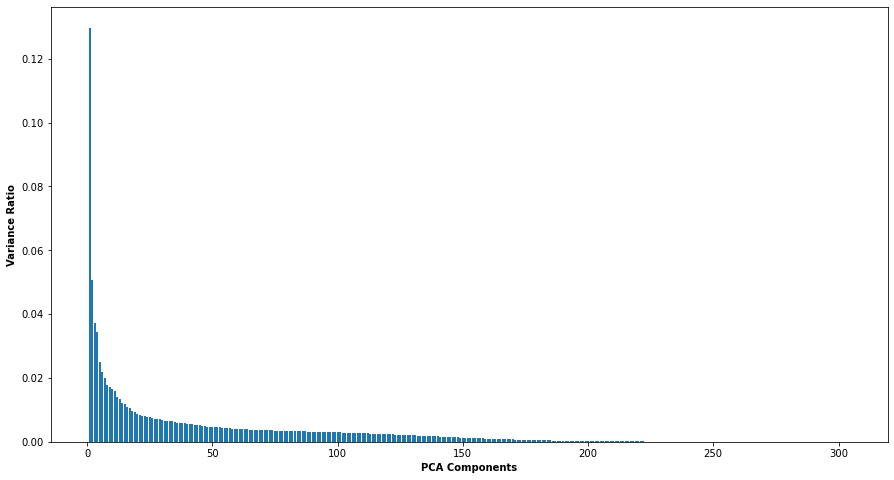

In [131]:
ax = plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel("PCA Components",fontweight = 'bold')
plt.ylabel("Variance Ratio",fontweight = 'bold')

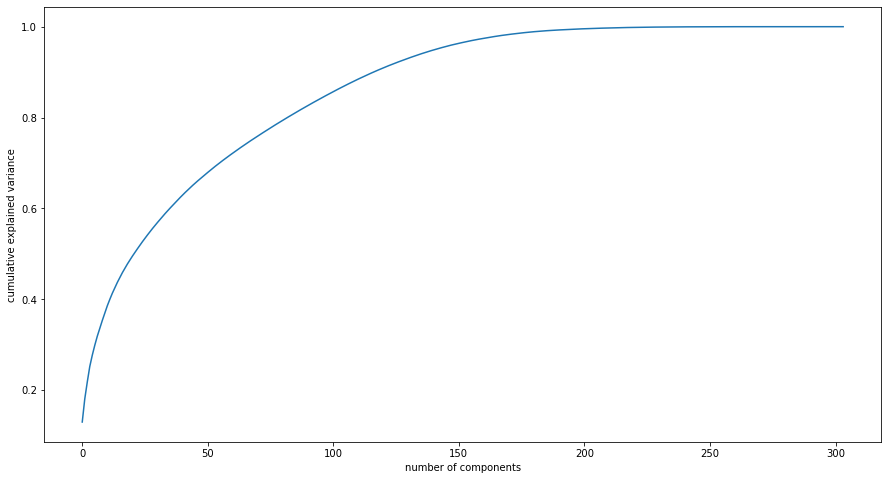

In [132]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [133]:
pd.DataFrame(pca.components_[0:5,:])

,0,1,2,3,4,5,6,7,8,9,...,294,295,296,297,298,299,300,301,302,303
0,-5.511245e-20,-6.938894e-18,0.006130,0.023683,0.002502,0.002811,-0.005366,0.002161,0.000887,0.009982,...,-0.012016,0.004344,-0.004503,0.003855,0.001851,-0.007988,-0.000504,-0.012137,0.011523,-0.015012
1,4.993264e-19,9.020562e-17,-0.030756,0.167646,-0.002186,-0.007946,0.005595,0.065772,-0.055970,0.017102,...,-0.057787,0.060695,-0.097289,0.021643,0.056476,-0.049927,-0.024877,-0.133572,0.021650,-0.153483
2,-9.437130e-19,-1.387779e-17,-0.100592,-0.073841,0.000305,0.002791,-0.004960,0.020607,-0.007567,-0.008084,...,0.168775,-0.092871,0.144490,-0.081826,-0.053605,0.167832,0.149507,0.025212,-0.080511,0.105565
3,2.311518e-18,-8.326673e-17,-0.033221,0.113542,0.017623,0.017663,0.008049,-0.010721,-0.033647,0.010486,...,0.059160,-0.204156,0.071781,-0.124569,-0.106284,0.108983,0.085904,0.046353,0.046590,0.059824
4,1.114657e-18,2.775558e-17,-0.024764,0.013304,-0.092098,-0.070947,-0.037175,-0.007325,0.024860,0.048112,...,-0.043188,-0.020587,-0.024360,-0.066073,0.085823,-0.016256,0.097940,-0.018132,0.092298,-0.067536


In [134]:
cl=[2,3]
for k in cl:
    clust_mod=KMeans(n_clusters=k,max_iter=1000,random_state=0)
    clust_mod.fit(pca_data[:,:2])
    print(k,silhouette_score(pca_data,clust_mod.labels_))

2 0.4724808280218005
3 0.05838328823212179


In [135]:
cl=[2,3]
for k in cl:
    clust_mod=KMeans(n_clusters=k,max_iter=1000,random_state=0)
    clust_mod.fit(df1)
    print(k,silhouette_score(df1,clust_mod.labels_))

2 0.6265445616984259
3 0.59021280266777


In [136]:
new_clusters = KMeans(n_clusters = 2, random_state = 10)

new_clusters.fit(pca_data[:,:2])

df['Cluster_PCA'] = new_clusters.labels_

In [137]:
df.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,URXUMS,URXUCR.x,URXCRS,URDACT,LBXSAL,LBDSALSI,LBXSAPSI,Cluster,Cluster_DBSCAN,Cluster_PCA
0,73557,8,2,1,69,4,4,1,103.0,1.0,...,-9.018023,-6.181923,5.151193,-9.708139,2.814690,-2.712184,-6.811191,0,-1,0
1,73558,8,2,1,54,3,3,1,103.0,2.0,...,8.289190,-2.561066,-3.755943,1.406037,7.590942,0.480820,-4.636475,0,-1,0
2,73559,8,2,1,72,3,3,2,103.0,1.0,...,-9.285869,9.248429,-7.439368,8.374918,8.401561,-9.936335,0.913262,0,-1,0
3,73560,8,2,1,9,3,3,1,119.0,2.0,...,-0.257756,-5.087773,8.581422,4.767615,9.760521,-4.708915,7.624684,0,-1,0
4,73561,8,2,2,73,3,3,1,103.0,2.0,...,-1.322955,-1.034636,6.702919,-1.735375,-4.799543,1.194572,-7.098007,0,-1,0


In [138]:
df_pca=df[['SEQN','Cluster_PCA']]
df_pca.head()

,SEQN,Cluster_PCA
0,73557,0
1,73558,0
2,73559,0
3,73560,0
4,73561,0


In [139]:
df_pca.to_csv("AlekhyaVemula_2.csv")

In [140]:
df_kmeans=df[['SEQN','Cluster']]
df_kmeans.head()
df_kmeans.to_csv("AlekhyaVemula_kmeans.csv")

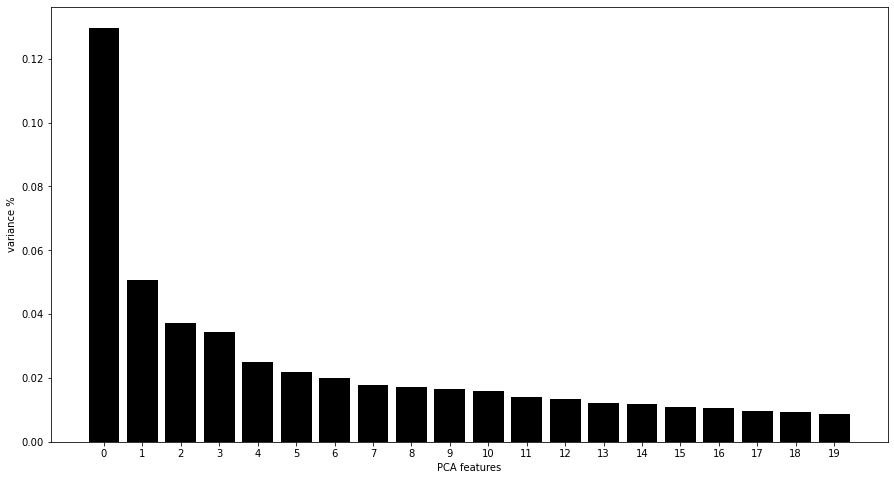

In [141]:
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

In [142]:
inertias = []
model = KMeans(n_clusters = 2)
model.fit(PCA_components.iloc[:,:2])
    
inertias.append(model.inertia_)

In [143]:
df['Cluster_PCA_1'] = model.labels_

In [144]:
df.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,URXUCR.x,URXCRS,URDACT,LBXSAL,LBDSALSI,LBXSAPSI,Cluster,Cluster_DBSCAN,Cluster_PCA,Cluster_PCA_1
0,73557,8,2,1,69,4,4,1,103.0,1.0,...,-6.181923,5.151193,-9.708139,2.814690,-2.712184,-6.811191,0,-1,0,0
1,73558,8,2,1,54,3,3,1,103.0,2.0,...,-2.561066,-3.755943,1.406037,7.590942,0.480820,-4.636475,0,-1,0,0
2,73559,8,2,1,72,3,3,2,103.0,1.0,...,9.248429,-7.439368,8.374918,8.401561,-9.936335,0.913262,0,-1,0,0
3,73560,8,2,1,9,3,3,1,119.0,2.0,...,-5.087773,8.581422,4.767615,9.760521,-4.708915,7.624684,0,-1,0,0
4,73561,8,2,2,73,3,3,1,103.0,2.0,...,-1.034636,6.702919,-1.735375,-4.799543,1.194572,-7.098007,0,-1,0,0


In [145]:
df_pca_1=df[['SEQN','Cluster_PCA_1']]
df_pca_1.head()
df_pca_1.to_csv("AlekhyaVemula_3.csv")

# LDA

In [146]:
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(22)
svd_data=svd.fit_transform(df1)

exp_var_ratio= svd.explained_variance_ratio_
exp_var_ratio.round(3)

cum_var=exp_var_ratio[0]
itr=2 
for j in exp_var_ratio[1:]:
    cum_var=cum_var+j
    if cum_var >= 0.95:
        break
    itr=itr+1

print('The number of svd components capturing 95 percent varaition is data is : ',itr,' Varaince explained is ', cum_var)

The number of svd components capturing 95 percent varaition is data is :  2  Varaince explained is  0.9999699652524211
